<a href="https://colab.research.google.com/github/mdsiam135/ICCIT2025/blob/main/NODE_(6).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Step-by-Step NODE (Neural Oblivious Decision Ensembles) Implementation
# Execute each step individually for better control and understanding

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("NODE (Neural Oblivious Decision Ensembles) for Agricultural Production Classification - 6 Class")
print("=" * 80)



NODE (Neural Oblivious Decision Ensembles) for Agricultural Production Classification - 6 Class


In [3]:


# ================================================================================
# STEP 1: Define the NODE Model Class
# ================================================================================

class NODEModel:
    """
    Neural Oblivious Decision Ensembles (NODE) implementation
    """

    def __init__(self, input_dim, num_classes, num_layers=3, tree_depth=6, num_trees=2048,
                 learning_rate=0.001, batch_size=512):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.tree_depth = tree_depth
        self.num_trees = num_trees
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.model = None
        self.history = None

    def build_model(self):
        """Build the NODE model architecture"""
        inputs = layers.Input(shape=(self.input_dim,))

        # Feature preprocessing
        x = layers.Dense(128, activation='relu')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.1)(x)

        # NODE layers (simplified implementation)
        for i in range(self.num_layers):
            # Oblivious decision tree simulation
            choice_function = layers.Dense(2**self.tree_depth, activation='sigmoid')(x)
            feature_selection = layers.Dense(self.tree_depth, activation='softmax')(x)

            # Tree ensemble
            tree_outputs = []
            for j in range(min(8, self.num_trees // (2**i + 1))):  # Reduced for computational efficiency
                tree_branch = layers.Dense(64, activation='relu')(x)
                tree_branch = layers.Dropout(0.1)(tree_branch)
                tree_outputs.append(tree_branch)

            if tree_outputs:
                x = layers.Add()(tree_outputs) if len(tree_outputs) > 1 else tree_outputs[0]

            x = layers.Dense(128, activation='relu')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Dropout(0.1)(x)

        # Final classification layer
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)

        self.model = keras.Model(inputs=inputs, outputs=outputs)

        # Compile model
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return self.model

    def train(self, X_train, y_train, X_val, y_val, epochs=100, verbose=1):
        """Train the NODE model"""
        if self.model is None:
            self.build_model()

        # Callbacks
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=15, restore_best_weights=True
        )

        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6
        )

        # Train model
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=self.batch_size,
            callbacks=[early_stopping, reduce_lr],
            verbose=verbose
        )

        return self.history

    def predict(self, X):
        """Make predictions"""
        return self.model.predict(X)

    def predict_classes(self, X):
        """Predict class labels"""
        predictions = self.predict(X)
        return np.argmax(predictions, axis=1)

print("✓ NODE Model class defined successfully")



✓ NODE Model class defined successfully


In [4]:



# ================================================================================
# STEP 2: Define Helper Functions
# ================================================================================

def load_and_preprocess_data():
    """Load and preprocess the CSV files"""
    print("Loading data...")

    # Load datasets
    train_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/training.csv')
    val_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/validating.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/testing.csv')

    print(f"Train shape: {train_df.shape}")
    print(f"Validation shape: {val_df.shape}")
    print(f"Test shape: {test_df.shape}")

    return train_df, val_df, test_df

def create_sextile_labels(df, target_col='Production (M.Ton)'):
    """Create sextile-based labels for production (6 categories)"""
    print("Creating sextile-based labels (6 categories)...")

    # Calculate sextiles (16.67%, 33.33%, 50%, 66.67%, 83.33%)
    sextiles = df[target_col].quantile([0.1667, 0.3333, 0.5, 0.6667, 0.8333]).values
    print(f"Sextile thresholds: {sextiles}")

    # Create labels
    def get_label(value):
        if value <= sextiles[0]:
            return 0  # Very Low
        elif value <= sextiles[1]:
            return 1  # Low
        elif value <= sextiles[2]:
            return 2  # Medium
        elif value <= sextiles[3]:
            return 3  # High
        elif value <= sextiles[4]:
            return 4  # Very High
        else:
            return 5  # Extremely High

    labels = df[target_col].apply(get_label)

    # Print label distribution
    label_names = ['Very Low', 'Low', 'Medium', 'High', 'Very High', 'Extremely High']
    print("Label distribution:")
    for i, name in enumerate(label_names):
        count = (labels == i).sum()
        print(f"{name}: {count} ({count/len(labels)*100:.1f}%)")

    return labels, sextiles

def preprocess_features(train_df, val_df, test_df, target_col='Production (M.Ton)'):
    """Preprocess features and prepare data for training"""
    print("Preprocessing features...")

    # Separate features and target
    feature_cols = [col for col in train_df.columns if col != target_col]

    X_train = train_df[feature_cols].copy()
    X_val = val_df[feature_cols].copy()
    X_test = test_df[feature_cols].copy()

    # Create labels
    y_train, train_sextiles = create_sextile_labels(train_df, target_col)

    # Use train sextiles for validation and test sets
    def apply_train_sextiles(df, sextiles, target_col):
        def get_label(value):
            if value <= sextiles[0]:
                return 0
            elif value <= sextiles[1]:
                return 1
            elif value <= sextiles[2]:
                return 2
            elif value <= sextiles[3]:
                return 3
            elif value <= sextiles[4]:
                return 4
            else:
                return 5
        return df[target_col].apply(get_label)

    y_val = apply_train_sextiles(val_df, train_sextiles, target_col)
    y_test = apply_train_sextiles(test_df, train_sextiles, target_col)

    # Handle missing values
    X_train = X_train.fillna(X_train.mean())
    X_val = X_val.fillna(X_train.mean())  # Use train mean for validation
    X_test = X_test.fillna(X_train.mean())  # Use train mean for test

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    print(f"Feature dimensions: {X_train_scaled.shape[1]}")
    print(f"Number of classes: {len(np.unique(y_train))}")

    return (X_train_scaled, y_train, X_val_scaled, y_val,
            X_test_scaled, y_test, scaler, train_sextiles)

def calculate_metrics(y_true, y_pred, dataset_name=""):
    """Calculate comprehensive classification metrics"""
    print(f"\n{dataset_name} Classification Metrics:")
    print("-" * 50)

    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro')
    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Macro): {precision_macro:.4f}")
    print(f"Precision (Weighted): {precision_weighted:.4f}")
    print(f"Recall (Macro): {recall_macro:.4f}")
    print(f"Recall (Weighted): {recall_weighted:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")

    # Detailed classification report
    print(f"\nDetailed Classification Report ({dataset_name}):")
    class_names = ['Very Low', 'Low', 'Medium', 'High', 'Very High', 'Extremely High']
    print(classification_report(y_true, y_pred, target_names=class_names))

    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }

def plot_confusion_matrix(y_true, y_pred, dataset_name="", figsize=(8, 6)):
    """Plot confusion matrix for 6 classes"""
    plt.figure(figsize=figsize)

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    class_names = ['Very Low', 'Low', 'Medium', 'High', 'Very High', 'Extremely High']

    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {dataset_name} (6-Class)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return cm

def plot_training_history(history, metric='accuracy'):
    """Plot training and validation metrics"""
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history[metric], label=f'Training {metric.title()}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric.title()}')
    plt.title(f'Model {metric.title()} (6-Class)')
    plt.xlabel('Epoch')
    plt.ylabel(metric.title())
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (6-Class)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

print("✓ All helper functions defined successfully")




✓ All helper functions defined successfully


In [5]:

# ================================================================================
# STEP 3: Load and Preprocess Data
# ================================================================================

print("\n" + "="*50)
print("STEP 3: LOADING AND PREPROCESSING DATA")
print("="*50)

# Load the datasets
train_df, val_df, test_df = load_and_preprocess_data()

print("✓ Data loaded successfully")




STEP 3: LOADING AND PREPROCESSING DATA
Loading data...
Train shape: (4928, 86)
Validation shape: (1056, 86)
Test shape: (1056, 86)
✓ Data loaded successfully


In [6]:
# ================================================================================
# STEP 4: Feature Preprocessing and Label Creation
# ================================================================================

print("\n" + "="*50)
print("STEP 4: FEATURE PREPROCESSING AND LABEL CREATION (6-CLASS)")
print("="*50)

# Preprocess features and create labels
(X_train, y_train, X_val, y_val,
 X_test, y_test, scaler, sextiles) = preprocess_features(train_df, val_df, test_df)

print("✓ Features preprocessed and 6-class labels created successfully")





STEP 4: FEATURE PREPROCESSING AND LABEL CREATION (6-CLASS)
Preprocessing features...
Creating sextile-based labels (6 categories)...
Sextile thresholds: [ 417.        996.5073   2027.       3717.4927   7522.298492]
Label distribution:
Very Low: 824 (16.7%)
Low: 819 (16.6%)
Medium: 821 (16.7%)
High: 821 (16.7%)
Very High: 821 (16.7%)
Extremely High: 822 (16.7%)
Feature dimensions: 85
Number of classes: 6
✓ Features preprocessed and 6-class labels created successfully


In [7]:

# ================================================================================
# STEP 5: Initialize and Build NODE Model
# ================================================================================

print("\n" + "="*50)
print("STEP 5: INITIALIZING AND BUILDING NODE MODEL (6-CLASS)")
print("="*50)

# Initialize NODE model for 6 classes
node_model = NODEModel(
    input_dim=X_train.shape[1],
    num_classes=6,  # Changed to 6 classes
    num_layers=3,
    tree_depth=6,
    num_trees=1024,  # Reduced for computational efficiency
    learning_rate=0.001,
    batch_size=256
)

# Build the model
model = node_model.build_model()
print(f"✓ 6-Class model built successfully with {model.count_params()} parameters")

# Display model architecture
print("\nModel Architecture Summary (6-Class):")
model.summary()




STEP 5: INITIALIZING AND BUILDING NODE MODEL (6-CLASS)
✓ 6-Class model built successfully with 236934 parameters

Model Architecture Summary (6-Class):


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 128)       │     11,008 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_35[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 64)        │      8,256 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 64)        │      8,256 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 64)        │      8,256 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 64)        │      8,256 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 64)        │      8,256 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 64)        │      8,256 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 64)        │      8,256 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_45 (Dense)    │ (None, 64)        │      8,256 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 64)        │          0 │ dense_38[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 64)        │          0 │ dense_39[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 64)        │          0 │ dense_40[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 64)        │          0 │ dense_41[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 64)        │          0 │ dense_42[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 64)        │          0 │ dense_43[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 64)        │          0 │ dense_44[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 64)        │          0 │ dense_45[0][0]  

 Total params: 236,934 (925.52 KB)

 Trainable params: 235,910 (921.52 KB)

 Non-trainable params: 1,024 (4.00 KB)

In [8]:



# ================================================================================
# STEP 6: Train the Model
# ================================================================================

print("\n" + "="*50)
print("STEP 6: TRAINING THE NODE MODEL (6-CLASS)")
print("="*50)

# Train the model
history = node_model.train(
    X_train, y_train,
    X_val, y_val,
    epochs=100,
    verbose=1
)

print("✓ 6-Class model training completed successfully")




STEP 6: TRAINING THE NODE MODEL (6-CLASS)
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - accuracy: 0.1929 - loss: 2.1872 - val_accuracy: 0.1610 - val_loss: 3.8622 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.2655 - loss: 1.8384 - val_accuracy: 0.2538 - val_loss: 2.1493 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3377 - loss: 1.6333 - val_accuracy: 0.3362 - val_loss: 1.7083 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3838 - loss: 1.5003 - val_accuracy: 0.4167 - val_loss: 1.3856 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4617 - loss: 1.3404 - val_accuracy: 0.4877 - val_loss: 1.2104 - learning_rate: 0.0010
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.5063 - loss: 1.2226 - val_accuracy: 0.5549 - val_loss: 1.1009 - learning_rate: 0.0010
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55


STEP 7: PLOTTING TRAINING HISTORY


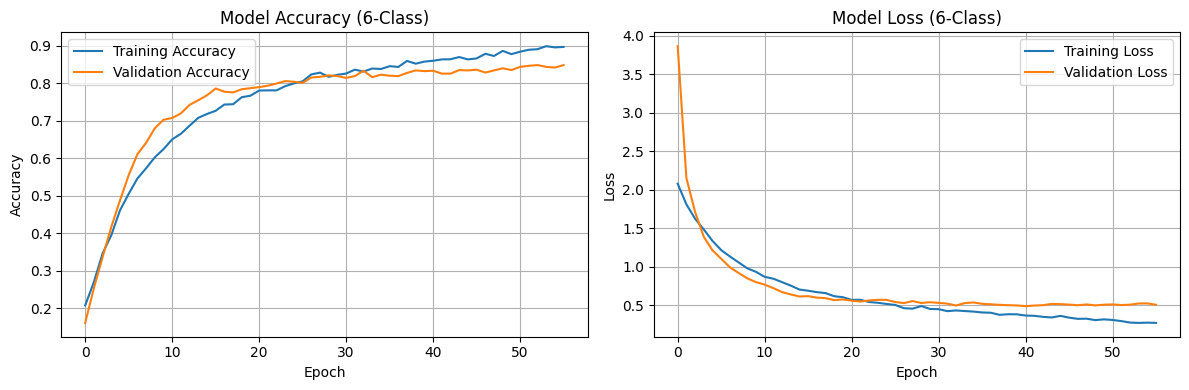

✓ Training history plotted


In [9]:


# ================================================================================
# STEP 7: Plot Training History
# ================================================================================

print("\n" + "="*50)
print("STEP 7: PLOTTING TRAINING HISTORY")
print("="*50)

# Plot training history
plot_training_history(history)
print("✓ Training history plotted")



In [10]:


# ================================================================================
# STEP 8: Make Predictions
# ================================================================================

print("\n" + "="*50)
print("STEP 8: MAKING PREDICTIONS")
print("="*50)

# Validation predictions
print("Making validation predictions...")
val_pred_proba = node_model.predict(X_val)
val_pred = np.argmax(val_pred_proba, axis=1)

# Test predictions
print("Making test predictions...")
test_pred_proba = node_model.predict(X_test)
test_pred = np.argmax(test_pred_proba, axis=1)

print("✓ 6-Class predictions completed successfully")






STEP 8: MAKING PREDICTIONS
Making validation predictions...
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Making test predictions...
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
✓ 6-Class predictions completed successfully


In [11]:


# ================================================================================
# STEP 9: Calculate Performance Metrics
# ================================================================================

print("\n" + "="*50)
print("STEP 9: CALCULATING PERFORMANCE METRICS (6-CLASS)")
print("="*50)

# Calculate metrics for validation set
val_metrics = calculate_metrics(y_val, val_pred, "Validation")

# Calculate metrics for test set
test_metrics = calculate_metrics(y_test, test_pred, "Test")

print("✓ 6-Class performance metrics calculated successfully")




STEP 9: CALCULATING PERFORMANCE METRICS (6-CLASS)

Validation Classification Metrics:
--------------------------------------------------
Accuracy: 0.8333
Precision (Macro): 0.8318
Precision (Weighted): 0.8329
Recall (Macro): 0.8322
Recall (Weighted): 0.8333
F1 Score (Macro): 0.8315
F1 Score (Weighted): 0.8325

Detailed Classification Report (Validation):
                precision    recall  f1-score   support

      Very Low       0.89      0.95      0.92       188
           Low       0.85      0.78      0.81       181
        Medium       0.79      0.77      0.78       170
          High       0.82      0.80      0.81       176
     Very High       0.77      0.80      0.79       171
Extremely High       0.87      0.90      0.88       170

      accuracy                           0.83      1056
     macro avg       0.83      0.83      0.83      1056
  weighted avg       0.83      0.83      0.83      1056


Test Classification Metrics:
-------------------------------------------------


STEP 10: GENERATING CONFUSION MATRICES (6x6)
Generating validation confusion matrix...


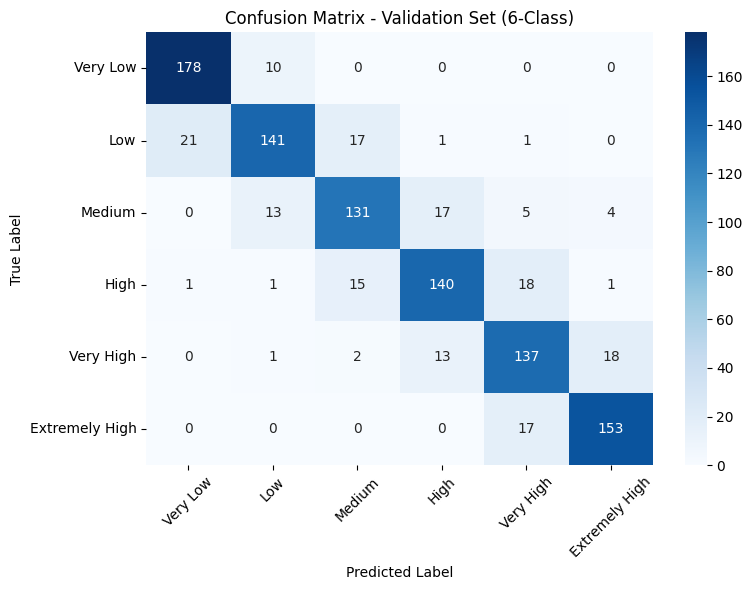

Generating test confusion matrix...


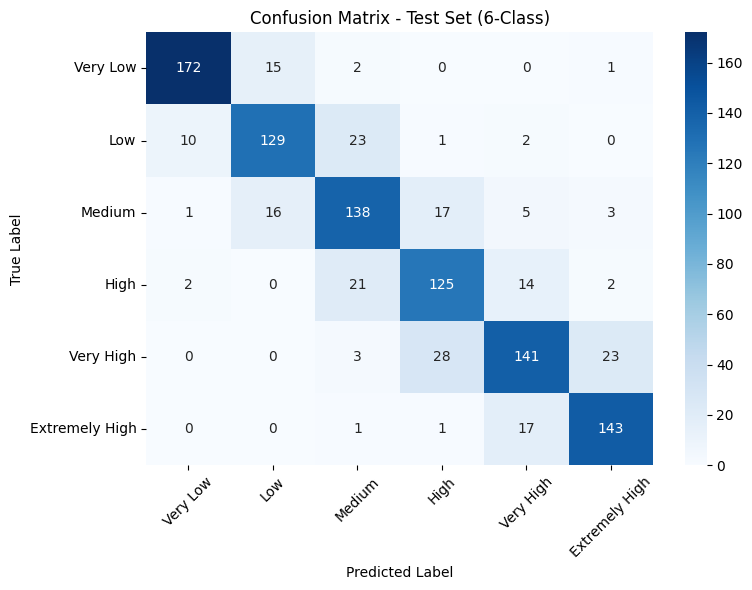

✓ 6x6 Confusion matrices generated successfully


In [12]:


# ================================================================================
# STEP 10: Generate Confusion Matrices
# ================================================================================

print("\n" + "="*50)
print("STEP 10: GENERATING CONFUSION MATRICES (6x6)")
print("="*50)

# Plot confusion matrices
print("Generating validation confusion matrix...")
val_cm = plot_confusion_matrix(y_val, val_pred, "Validation Set")

print("Generating test confusion matrix...")
test_cm = plot_confusion_matrix(y_test, test_pred, "Test Set")

print("✓ 6x6 Confusion matrices generated successfully")


In [13]:

# ================================================================================
# STEP 11: Final Results Summary
# ================================================================================

print("\n" + "="*80)
print("STEP 11: FINAL RESULTS SUMMARY (6-CLASS)")
print("="*80)

print(f"Validation Accuracy: {val_metrics['accuracy']:.4f}")
print(f"Validation Macro F1: {val_metrics['f1_macro']:.4f}")
print(f"Validation Weighted F1: {val_metrics['f1_weighted']:.4f}")
print()
print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Test Macro F1: {test_metrics['f1_macro']:.4f}")
print(f"Test Weighted F1: {test_metrics['f1_weighted']:.4f}")

# Display sextile information
print(f"\nSextile Thresholds Used:")
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High', 'Extremely High']
print(f"Very Low: ≤ {sextiles[0]:.3f}")
print(f"Low: {sextiles[0]:.3f} - {sextiles[1]:.3f}")
print(f"Medium: {sextiles[1]:.3f} - {sextiles[2]:.3f}")
print(f"High: {sextiles[2]:.3f} - {sextiles[3]:.3f}")
print(f"Very High: {sextiles[3]:.3f} - {sextiles[4]:.3f}")
print(f"Extremely High: > {sextiles[4]:.3f}")

print("\n✓ 6-CLASS NODE MODEL TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!")
print("="*80)





STEP 11: FINAL RESULTS SUMMARY (6-CLASS)
Validation Accuracy: 0.8333
Validation Macro F1: 0.8315
Validation Weighted F1: 0.8325

Test Accuracy: 0.8030
Test Macro F1: 0.8026
Test Weighted F1: 0.8031

Sextile Thresholds Used:
Very Low: ≤ 417.000
Low: 417.000 - 996.507
Medium: 996.507 - 2027.000
High: 2027.000 - 3717.493
Very High: 3717.493 - 7522.298
Extremely High: > 7522.298

✓ 6-CLASS NODE MODEL TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!


In [14]:




# ================================================================================
# STEP 12: Additional Analysis (Optional)
# ================================================================================

print("\n" + "="*50)
print("STEP 12: ADDITIONAL ANALYSIS")
print("="*50)

# Feature importance analysis (if needed)
print("6-Class NODE model is ready for additional analysis or predictions on new data.")

# You can now use the trained model for predictions:
# new_predictions = node_model.predict(new_data_scaled)
# new_classes = node_model.predict_classes(new_data_scaled)


STEP 12: ADDITIONAL ANALYSIS
6-Class NODE model is ready for additional analysis or predictions on new data.
